<a href="https://colab.research.google.com/github/TariqLisse/SequentialArt_StableDiffusion/blob/main/stablediffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade diffusers accelerate transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.3/297.3 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [18]:
'''The first step is to utilize a text-to-image pipeline to generate an image from a text description
A diffusion model take a prompt (text description) and some random initial noise,
and iteratively removes the noise to contruct an image.

The denoising process is is guided by the prompt, and once the denoising process ends after a
predetermined number of time steps, the image representation is decoded into an image

1. Load a checkpoint into the AutoPipelineForText2Image class, which automatically detects the appropriate
pipeline class to use based on the checkpoint:'''

from diffusers import AutoPipelineForText2Image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

'''2. Pass a prompt to the pipeline to generate an image:

The height and width parameters control the height and width (in pixels) of the generated image

Guidance Scale parameter affects how much the prompt influences image generation.
A lower value gives the model "creativity" to generate images that are more loosely related to the prompt.
Higher guidance_scale values push the model to follow the prompt more closely,
If the value is too high, some artifacts are observable in the generated image.

Negative Prompt: A negative prompt steers the model away from things you don't want the model to generate.
This is used to improve overall quality by removing poor or bad image features such as "low resolution" or "bad details".
You can also use a negative prompt to remove or modify the content and style of an image.

A torch.Generator object enables reproducibility in a pipeline by setting a manual seed. You can use a Generator
to generate batches of images and iteratively improve on an image generated from a seed. You can set a seed and
creating an image with a Generator should return the same result each time instead of randomly generating a new image
'''

generator = torch.Generator(device="cuda").manual_seed(30)

image = pipeline(
    prompt="black boy, warrior, fantasy, cartoon",
    height=768, width=512, guidance_scale=12.5,
    negative_prompt="bad anatomy, bad composition, ugly, abnormal, unrealistic, double, contorted, disfigured, malformed, amateur, extra, duplicate",
    generator=generator,
).images[0]
image
image.save("character.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

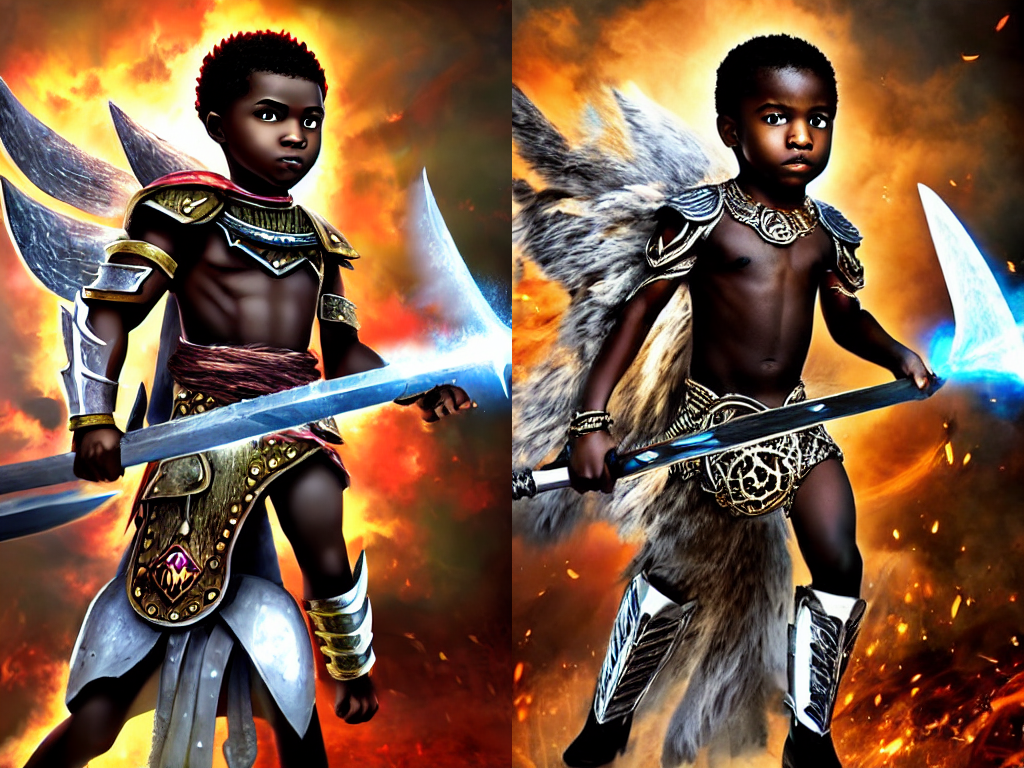

In [33]:
'''Extending the pipeline to generate a new image
based on the saved image and a new prompt by using an Image2Image pipeline'''

import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.enable_model_cpu_offload()

# prepare image
saved_image = "character.png"
init_image = load_image(saved_image)

'''1. Strength is an important paramater to consider as it has a huge impact on the generated image.
Strength determines how much the generated image resembles the initial image.
A higher strength value gives the model more "creativity" to generate an image that's different from the initial image;
A strength value of 1.0 means the initial image is more or less ignored

A lower strength value means the generated image is more similar to the initial image

strength and num_inference_steps parameters are related because strength determines the number of noise steps to add.
For example, if the num_inference_steps is 50 and strength is 0.8, then this means adding 40 (50 * 0.8)
steps of noise to the initial image and then denoising for 40 steps to get the newly generated image

The guidance_scale parameter is used to control how closely aligned the generated image and text prompt are.
A higher guidance_scale value means your generated image is more aligned with the prompt
A lower guidance_scale value means your generated image has more space to deviate from the prompt

You can combine guidance_scale with strength for even more precise control over how expressive the model is.
For example, combining a high strength + guidance_scale for maximum creativity or use a combination of low strength
and low guidance_scale to generate an image that resembles the initial image but is not as strictly bound to the prompt.

A negative prompt conditions the model to NOT include things in an image, and can be used to improve image quality or modify an image'''

prompt = "black boy, warrior, fantasy, cartoon"
negative_prompt = "ugly, deformed, disfigured, poor details, bad anatomy"
generator = torch.Generator(device="cuda").manual_seed(30)

# Pass Prompt and image to pipeline
image = pipeline(prompt, negative_prompt=negative_prompt, image=init_image, strength=0.75, guidance_scale=12.5, generator=generator).images[0]
make_image_grid([init_image, image], rows=1, cols=2)
#image.save("new_character.png")

